# Concurrency
`Python 3.10.8`

- Concurrency is about dealing with lots of things at once.
- Parallelism is about doing lots of things at once.
- Not the same, but related.
- One is about structure, one is about execution.
- Concurrency provides a way to structure a solution to solve a problem that may (but not necessarily) be parallelizable.

Parallelism is a special case of concurrency, in Pike’s view. All parallel systems are concurrent, but not all concurrent systems are parallel.
> there are two major sins in science: using different words to mean the same thing and using one word to mean different things.
- A modern laptop with 4 CPU cores is routinely running more than 200 processes at any given time under normal, casual use. To execute 200 tasks in parallel, you’d need 200 cores. So, in practice, most computing is concurrent and not parallel
- Python’s core packages for concurrent programming: `threading`, `multi processing`, and `asyncio`.

# A Bit of Jargon
- `Concurrency`: 能夠處理數個 pending 的任務，讓 progress 被分配去執行，就是 multitasking 的意思。
- `Parallelism`: The ability to execute multiple computations at the same time. This requires a multicore CPU, multiple CPUs, a GPU, or multiple computers in a cluster.
- `Execution unit`: General term for objects that execute code concurrently, each with independent state and call stack. Python natively supports three kinds of execution units: `processes`, `threads`, and `coroutines`.
- `Process`: 有自己獨立 CPU 使用時間和 Memory 空間的 Computer program.
- `Thread`: Process 的執行單位，會 Share 同一個 Process 的 Memory.
- `Coroutine`: A function that can suspend itself and resume later. In Python, `classic coroutines` are built from generator functions, and `native coroutines` are defined with `async`. Chapter 21 covers the use of native coroutines.
- `Queue`: A data structure. 通常（不一定）是 FIFO。 Queues allow separate execution units to exchange application data and control messages, such as error codes and signals to terminate.
- `Lock`: An object that execution units can use to synchronize their actions and avoid corrupting data.
- `Contention`: Dispute over a limited asset. Resource contention happens when multiple execution units try to access a shared resource—such as a lock or storage.

# Processes, Threads, and Python’s Infamous GIL (Global Interpreter Lock)
1. Each instance of the Python interpreter is a process.
2. The Python interpreter uses a single thread to run the user’s program and the memory garbage collector.
3. Only one Python thread can hold the GIL at any time. This means that only one thread can execute Python code at any time.
4. Prevent indefinitely thread → Realse in every 5ms → OS pick one
5. Any language that interfaces at the Python/C API level can release the GIL while running time-consuming tasks.
6. Every Python standard library function that makes a syscall5 releases the GIL.
7. Extensions that integrate at the Python/C API level can also launch other nonPython threads that are not affected by the GIL.
8. I/O, reading, or writing → high latency → "Python threads are great at doing nothing."
9. Contention over the GIL slows down compute-intensive Python threads.
10. To run CPU-intensive Python code on multiple cores, you must use multiple Python processes.

**Summary**
- In CPython, due to GIL only one thread can execute Python code at once.
- Threading is still an appropriate model if you want to run multiple I/O-bound taskssimultaneously.
- Better use of the computational resources → `multiprocessing` or `concurrent.futures.ProcessPoolExecutor`. 

# A Concurrent Hello World
An `Event` instance has an internal boolean flag that starts as `False`. Calling `Event.set()` sets the flag to `True`. While the flag is `false`, if a thread calls `Event.wait()`, it is blocked until another thread calls `Event.set()`, at which time `Event.wait()` returns `True`. If a timeout in seconds is given to `Event.wait(s)`, this call `returns` False when the timeout elapses, or returns `True` as soon as `Event.set()` is called by another thread.


In [1]:
import itertools
import time
from threading import Thread, Event

def spin(msg: str, done: Event) -> None:  # done → instance of threading.Event
    for char in itertools.cycle(r'\|/-'):  # itertools.cycle yields one character at a time → infinite loop
        status = f'\r{char} {msg}'
        print(status, end='', flush=True)
        if done.wait(.1):  # Returns True when the event is set by another thread
            break
    blanks = ' ' * len(status)
    print(f'\r{blanks}\r', end='')

def slow() -> int:
    time.sleep(3)
    return 42

def supervisor() -> int:
    done = Event()
    spinner = Thread(target=spin, args=('thinking!', done))  # Create a new Thread
    print(f'spinner object: {spinner}')  # Initial is the state of the thread, meaning it has not started
    spinner.start()  # Start the spinner thread
    result = slow()
    done.set()  # Set the Event flag to True; this will terminate the for loop inside the spin function
    spinner.join()  # Wait until the spinner thread finishes
    return result

def main() -> None:
    result = supervisor()
    print(f'Answer: {result}')

if __name__ == '__main__':
    main()

spinner object: <Thread(Thread-5 (spin), initial)>
Answer: 42  


# Spinner with Processes
The `multiprocessing` package supports running concurrent tasks in separate Python processes instead of threads.

In [2]:
import itertools
import time
from multiprocessing import Process, Event  # Multiprocessing.Event is a function (not a class like threading.Event) which returns a synchronize.Event instance.
from multiprocessing import synchronize

def spin(msg: str, done: synchronize.Event) -> None:
    for char in itertools.cycle(r'\|/-'):
        status = f'\r{char} {msg}'
        print(status, end='', flush=True)
        if done.wait(.1):  
            break
    blanks = ' ' * len(status)
    print(f'\r{blanks}\r', end='')

def slow() -> int:
    time.sleep(3)
    return 42
    
def supervisor() -> int:
    done = Event()
    spinner = Process(target=spin,
                      args=('thinking!', done))
    print(f'spinner object: {spinner}')
    spinner.start()
    result = slow()
    done.set()
    spinner.join()
    return result

def main() -> None:
    result = supervisor()
    print(f'Answer: {result}')


if __name__ == '__main__':
    main()

spinner object: <Process name='Process-1' parent=13216 initial>
Answer: 42


The basic API of `threading` and `multiprocessing` are similar, but their implementation is very different, and `multiprocessing` has a much larger API to handle the added complexity of multiprocess programming. For example, one challenge when converting from threads to processes is how to communicate between processes that are isolated by the operating system and can’t share Python objects. This means that objects crossing process boundaries have to be serialized and deserialized, which creates overhead. In previous example, the only data that crosses the process boundary is the `Event` state, which is implemented with a low-level OS semaphore in the C code underlying the multiprocessing module.

# Spinner with Coroutines
It is the job of OS schedulers to allocate CPU time to drive threads and processes. In contrast, coroutines are driven by an application-level event loop that manages a queue of pending coroutines, drives them one by one, monitors events triggered by I/O operations initiated by coroutines, and passes control back to the corresponding coroutine when each event happens.
- [Jupyter is already running an event loop.](https://stackoverflow.com/questions/55409641/asyncio-run-cannot-be-called-from-a-running-event-loop-when-using-jupyter-no)

In [3]:
import asyncio
import itertools

async def spin(msg: str) -> None:
    for char in itertools.cycle(r'\|/-'):
        status = f'\r{char} {msg}'
        print(status, flush=True, end='')
        try:
            await asyncio.sleep(.1)
        except asyncio.CancelledError: # asyncio.CancelledError is raised when the cancel method is called on the Task controlling this coroutine.
            break
    blanks = ' ' * len(status)
    print(f'\r{blanks}\r', end='')

async def slow() -> int:
    await asyncio.sleep(3)
    return 42

async def supervisor() -> int:
    spinner = asyncio.create_task(spin('thinking!'))  # asyncio.create_task schedules the eventual execution of spin, immediately returning an instance of asyncio.Task.
    print(f'spinner object: {spinner}')
    result = await slow()  # Call slow, blocking supervisor
    spinner.cancel()  # Raises a CancelledError
    return result

def main() -> None:  # The only regular function defined in this program, the others are coroutines.
    result = asyncio.run(supervisor())  # Start the event loop → main function will stay blocked.
    print(f'Answer: {result}')

if __name__ == '__main__':
    main()

RuntimeError: asyncio.run() cannot be called from a running event loop

# Thread vs asyncio
- `thread`: Object, Non-API, Not protected against GIL.
- `asyncio`: Yield, API, Protected against GIL.

# Question

`is_prime` is a normal function that needs 3 seconds to finish. 
1. In `spinner_proc.py`, replace `time.sleep(3)` with a call to `is_prime(n)`?
2. In `spinner_thread.py`, replace `time.sleep(3)` with a call to `is_prime(n)`?
3. In `spinner_async.py`, replace `await asyncio.sleep(3)` with a call to `is_prime(n)`?


# A Homegrown Process Pool
- `P` if it’s a prime number, blank if not.

### Process-Based Solution

In [4]:
from time import perf_counter
from typing import NamedTuple

from primes import is_prime, NUMBERS

class Result(NamedTuple):  # Returns a Result tuple with the boolean value of the is_prime call and the elapsed time.
    prime: bool
    elapsed: float

def check(n: int) -> Result:  # Computes the elapsed time to return a Result.
    t0 = perf_counter()
    prime = is_prime(n)
    return Result(prime, perf_counter() - t0)

def main() -> None:
    print(f'Checking {len(NUMBERS)} numbers sequentially:')
    t0 = perf_counter()
    for n in NUMBERS:
        prime, elapsed = check(n)
        label = 'P' if prime else ' '
        print(f'{n:16}  {label} {elapsed:9.6f}s')

    elapsed = perf_counter() - t0  # Compute and display the total elapsed time.
    print(f'Total time: {elapsed:.2f}s')

if __name__ == '__main__':
    main()

Checking 20 numbers sequentially:
               2  P  0.000001s
 142702110479723  P  0.802464s
 299593572317531  P  1.151013s
3333333333333301  P  4.131544s
3333333333333333     0.000027s
3333335652092209     4.018913s
4444444444444423  P  4.837732s
4444444444444444     0.000001s
4444444488888889     4.498427s
5555553133149889     4.930612s
5555555555555503  P  5.215737s
5555555555555555     0.000006s
6666666666666666     0.000001s
6666666666666719  P  5.852760s
6666667141414921     5.995728s
7777777536340681     6.407735s
7777777777777753  P  6.112961s
7777777777777777     0.000006s
9999999999999917  P  6.857096s
9999999999999999     0.000006s
Total time: 60.81s


### Code for the Multicore Prime Checker
- When we delegate computing to threads or processes, our code does not call the worker function directly, so we can’t simply get a return value.

In [5]:
import sys
from time import perf_counter
from typing import NamedTuple
from multiprocessing import Process, SimpleQueue, cpu_count
from multiprocessing import queues

from primes import is_prime, NUMBERS

class PrimeResult(NamedTuple):
    n: int
    prime: bool
    elapsed: float

JobQueue = queues.SimpleQueue[int]  # Send numbers to the processes that will do the work
ResultQueue = queues.SimpleQueue[PrimeResult]  # Collect the results in main

def check(n: int) -> PrimeResult:
    t0 = perf_counter()
    res = is_prime(n)
    return PrimeResult(n, res, perf_counter() - t0)

def worker(jobs: JobQueue, results: ResultQueue) -> None:
    while n := jobs.get():
        results.put(check(n))  # Enqueue PrimeResult
    results.put(PrimeResult(0, False, 0.0))  # Let the main loop know that this worker is done.

def start_jobs(
    procs: int, jobs: JobQueue, results: ResultQueue  # Compute the prime checks in parallel.
) -> None:
    for n in NUMBERS:
        jobs.put(n)  # Enqueue the numbers to be checked in jobs.
    for _ in range(procs):
        proc = Process(target=worker, args=(jobs, results))  # Fork a child process for each worker.
        proc.start()  # Start each child process.
        jobs.put(0)  # Enqueue one 0 for each process, to terminate them

def main() -> None:
    if len(sys.argv) < 2:
        procs = cpu_count()
    else:
        procs = int(sys.argv[1])

    print(f'Checking {len(NUMBERS)} numbers with {procs} processes:')
    t0 = perf_counter()
    jobs: JobQueue = SimpleQueue()
    results: ResultQueue = SimpleQueue()
    start_jobs(procs, jobs, results)  # Start proc processes to consume jobs and post results.
    checked = report(procs, results)  # Retrieve the results and display them.
    elapsed = perf_counter() - t0
    print(f'{checked} checks in {elapsed:.2f}s')

def report(procs: int, results: ResultQueue) -> int:
    checked = 0
    procs_done = 0
    while procs_done < procs:
        n, prime, elapsed = results.get()
        if n == 0:
            procs_done += 1
        else:
            checked += 1
            label = 'P' if prime else ' '
            print(f'{n:16}  {label} {elapsed:9.6f}s')
    return checked

if __name__ == '__main__':
    main()

ValueError: invalid literal for int() with base 10: '-f'

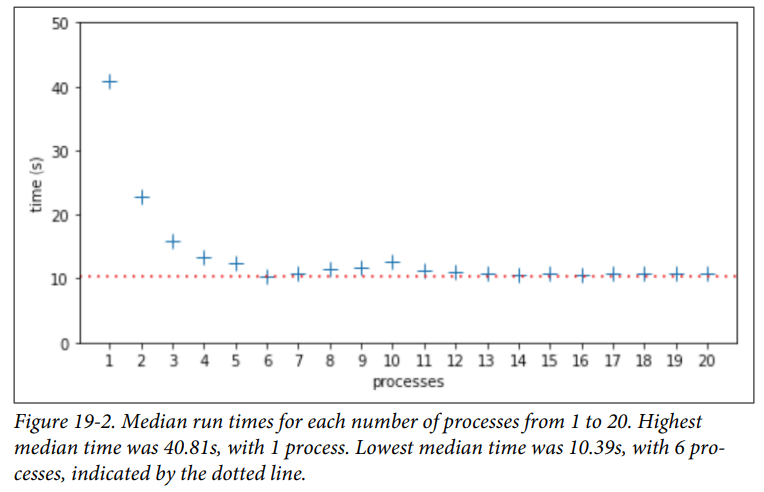

# Conclusion
- Threads, with the `threading` package
- Processes, with `multiprocessing`
- Asynchronous coroutines with `asyncio`

# Reference
- [Fluent Python Chpater 10 Design Patterns with First-Class Functions](https://bibis.ir/science-books/programming/python/2022/Fluent%20Python%20Clear,%20Concise,%20and%20Effective%20Programming,%202nd%20Edition%20by%20Luciano%20Ramalho_bibis.ir.pdf), Page (725 - 771) / 1011
- [Fluent Python second edition example code](https://github.com/fluentpython/example-code-2e/tree/master/19-concurrency)